In [2]:
import numpy as np
import os
import random
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from pathlib import Path

import time

import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pylab as plt

import plotly
import plotly.graph_objects as go

import optuna
from sklearn import metrics

c:\Users\Admin\AppData\Local\pypoetry\Cache\virtualenvs\pattern-or-coincidence-C1iknuGQ-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = "minutes_21"
path = Path().resolve().parents[0] / f"data/raw/{name}.csv"

In [4]:
df = pd.read_csv(path)
df["begin"] = pd.to_datetime(df["begin"])
df.head()

,begin,open,close,high,low,value
0,2021-01-04 09:59:00,274.67,274.67,274.67,274.67,33910758.2
1,2021-01-04 10:00:00,274.67,274.00,274.67,273.10,236436377.8
2,2021-01-04 10:01:00,274.00,273.77,274.44,273.72,56647825.9
3,2021-01-04 10:02:00,273.76,273.63,273.84,273.38,55542122.2
4,2021-01-04 10:03:00,273.52,273.71,274.00,273.52,59676343.0


In [5]:
def data_division(data, period=60, part_len=500, rolling=20):
    """Разбиваем строго внутри дня, по {period} минут, последовательно

    Args:
        data (DataFrame, optional): _description_. Defaults to data.
        period (int, optional): _description_. Defaults to 60.

    Returns:
        DataFrame: _description_
    """
    data["rolling"] = data.close.rolling(rolling).mean()
    data.dropna(axis=0, inplace=True)

    df_open = data[["begin", "rolling"]]
    df_grouped = df_open.groupby([df_open["begin"].dt.date])
    full_range = []

    for dates in list(df_grouped.groups.keys()):
        df_day = df_grouped.get_group(dates)
        my_list = list(df_day["rolling"])
        composite_list = [
            my_list[x : x + period] for x in range(0, len(my_list), period)
        ]
        # drop last cause not sure if it has full period
        composite_list = composite_list[:-1]
        full_range += composite_list

    new_df = pd.DataFrame(full_range)

    # lets start with small part

    np.random.seed(0)
    new_df = new_df.iloc[list(np.random.choice(range(len(new_df)), part_len))]
    df_norm = TimeSeriesScalerMeanVariance().fit_transform(new_df.values)

    print(new_df.shape)
    print(rolling)

    return df_norm

In [6]:
def k_shape_cl(X_train, n_clusters=5):
    sz = X_train.shape[1]

    seed = np.random.seed(0)

    # kShape
    # ks = KShape(n_clusters=n_clusters, verbose=True, random_state=seed)
    ks = KShape(
        n_clusters=n_clusters,
        max_iter=100,
        n_init=1,
        random_state=seed,
        verbose=True,
    )
    y_pred = ks.fit_predict(X_train)
    # y_pred = ks.fit_predict(X_train)

    return y_pred, ks

In [7]:
def cluster_visuliation(model, X_train, y_pred, n_clusters):
    nc = int(n_clusters)
    sz = X_train.shape[1]
    ks = model

    plt.figure(figsize=(12, nc * 4))
    for yi in range(nc):
        plt.subplot(nc, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.title(
            f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries"
        )

    plt.tight_layout()
    plt.show()

In [8]:
def cl_num(X):
    seed = np.random.seed(0)
    distortions = []
    for i in tqdm(range(15, 20)):
        # time.sleep(0.25)
        ks = KShape(n_clusters=i, n_init=5, verbose=False, random_state=seed)
        ks.fit(X)
        distortions.append(ks.inertia_)
    plt.plot(range(15, 20), distortions, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("Distortion Line")
    plt.show()

In [11]:
def metric(data, y_pred):
    data_2d = data.reshape(data.shape[:2])

    sil = metrics.silhouette_score(
        data_2d,
        y_pred,
        metric="euclidean",
    )

    return sil

In [12]:
# Подбор параметров Optuna


def objective(trial):
    rolling = trial.suggest_int("rolling", 20, 40, step=10)
    period = trial.suggest_int("period", 20, 60, step=10)
    n_clusters = trial.suggest_int("n_clusters", 5, 20, step=5)

    df_n = data_division(
        data=df, period=period, part_len=1000, rolling=rolling
    )
    y_pred, mod = k_shape_cl(df_n, n_clusters)

    sil = metric(df_n, y_pred)

    return sil


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

study.best_params

[I 2023-04-20 19:24:29,799] A new study created in memory with name: no-name-0917e281-a169-449d-8da6-88773a778d02


(1000, 60)
30
0.010 --> 0.009 --> 0.009 --> 0.008 --> 0.008 --> 


[I 2023-04-20 19:25:00,286] Trial 0 finished with value: 0.19432832169404396 and parameters: {'rolling': 30, 'period': 60, 'n_clusters': 15}. Best is trial 0 with value: 0.19432832169404396.


(1000, 50)
40
0.017 --> 0.015 --> 0.014 --> 0.014 --> 0.014 --> 0.013 --> 0.013 --> 0.013 --> 0.013 --> 


[I 2023-04-20 19:25:17,735] Trial 1 finished with value: 0.3404333636859085 and parameters: {'rolling': 40, 'period': 50, 'n_clusters': 5}. Best is trial 1 with value: 0.3404333636859085.


(1000, 50)
30
0.010 --> 0.010 --> 


[I 2023-04-20 19:25:30,742] Trial 2 finished with value: 0.18781643061114356 and parameters: {'rolling': 30, 'period': 50, 'n_clusters': 10}. Best is trial 1 with value: 0.3404333636859085.


(1000, 30)
40
0.006 --> 0.007 --> 


[I 2023-04-20 19:25:46,717] Trial 3 finished with value: 0.1890176155047937 and parameters: {'rolling': 40, 'period': 30, 'n_clusters': 15}. Best is trial 1 with value: 0.3404333636859085.


(1000, 20)
30
0.010 --> 0.011 --> 


[I 2023-04-20 19:25:57,870] Trial 4 finished with value: 0.18194829992147427 and parameters: {'rolling': 30, 'period': 20, 'n_clusters': 10}. Best is trial 1 with value: 0.3404333636859085.


(1000, 20)
30
0.016 --> 0.018 --> 


[I 2023-04-20 19:26:03,876] Trial 5 finished with value: 0.2590511971164754 and parameters: {'rolling': 30, 'period': 20, 'n_clusters': 5}. Best is trial 1 with value: 0.3404333636859085.


(1000, 60)
20
0.011 --> 0.010 --> 0.010 --> 0.010 --> 0.010 --> 


[I 2023-04-20 19:26:34,300] Trial 6 finished with value: 0.08486479900134344 and parameters: {'rolling': 20, 'period': 60, 'n_clusters': 15}. Best is trial 1 with value: 0.3404333636859085.


(1000, 20)
40
0.012 --> 0.014 --> 


[I 2023-04-20 19:26:45,287] Trial 7 finished with value: 0.09062581298925362 and parameters: {'rolling': 40, 'period': 20, 'n_clusters': 10}. Best is trial 1 with value: 0.3404333636859085.


(1000, 50)
30
0.006 --> 0.006 --> 


[I 2023-04-20 19:27:04,083] Trial 8 finished with value: 0.19487679828187862 and parameters: {'rolling': 30, 'period': 50, 'n_clusters': 15}. Best is trial 1 with value: 0.3404333636859085.


(1000, 50)
30
0.015 --> 0.015 --> 


[I 2023-04-20 19:27:11,136] Trial 9 finished with value: 0.28819056333729076 and parameters: {'rolling': 30, 'period': 50, 'n_clusters': 5}. Best is trial 1 with value: 0.3404333636859085.


{'rolling': 40, 'period': 50, 'n_clusters': 5}

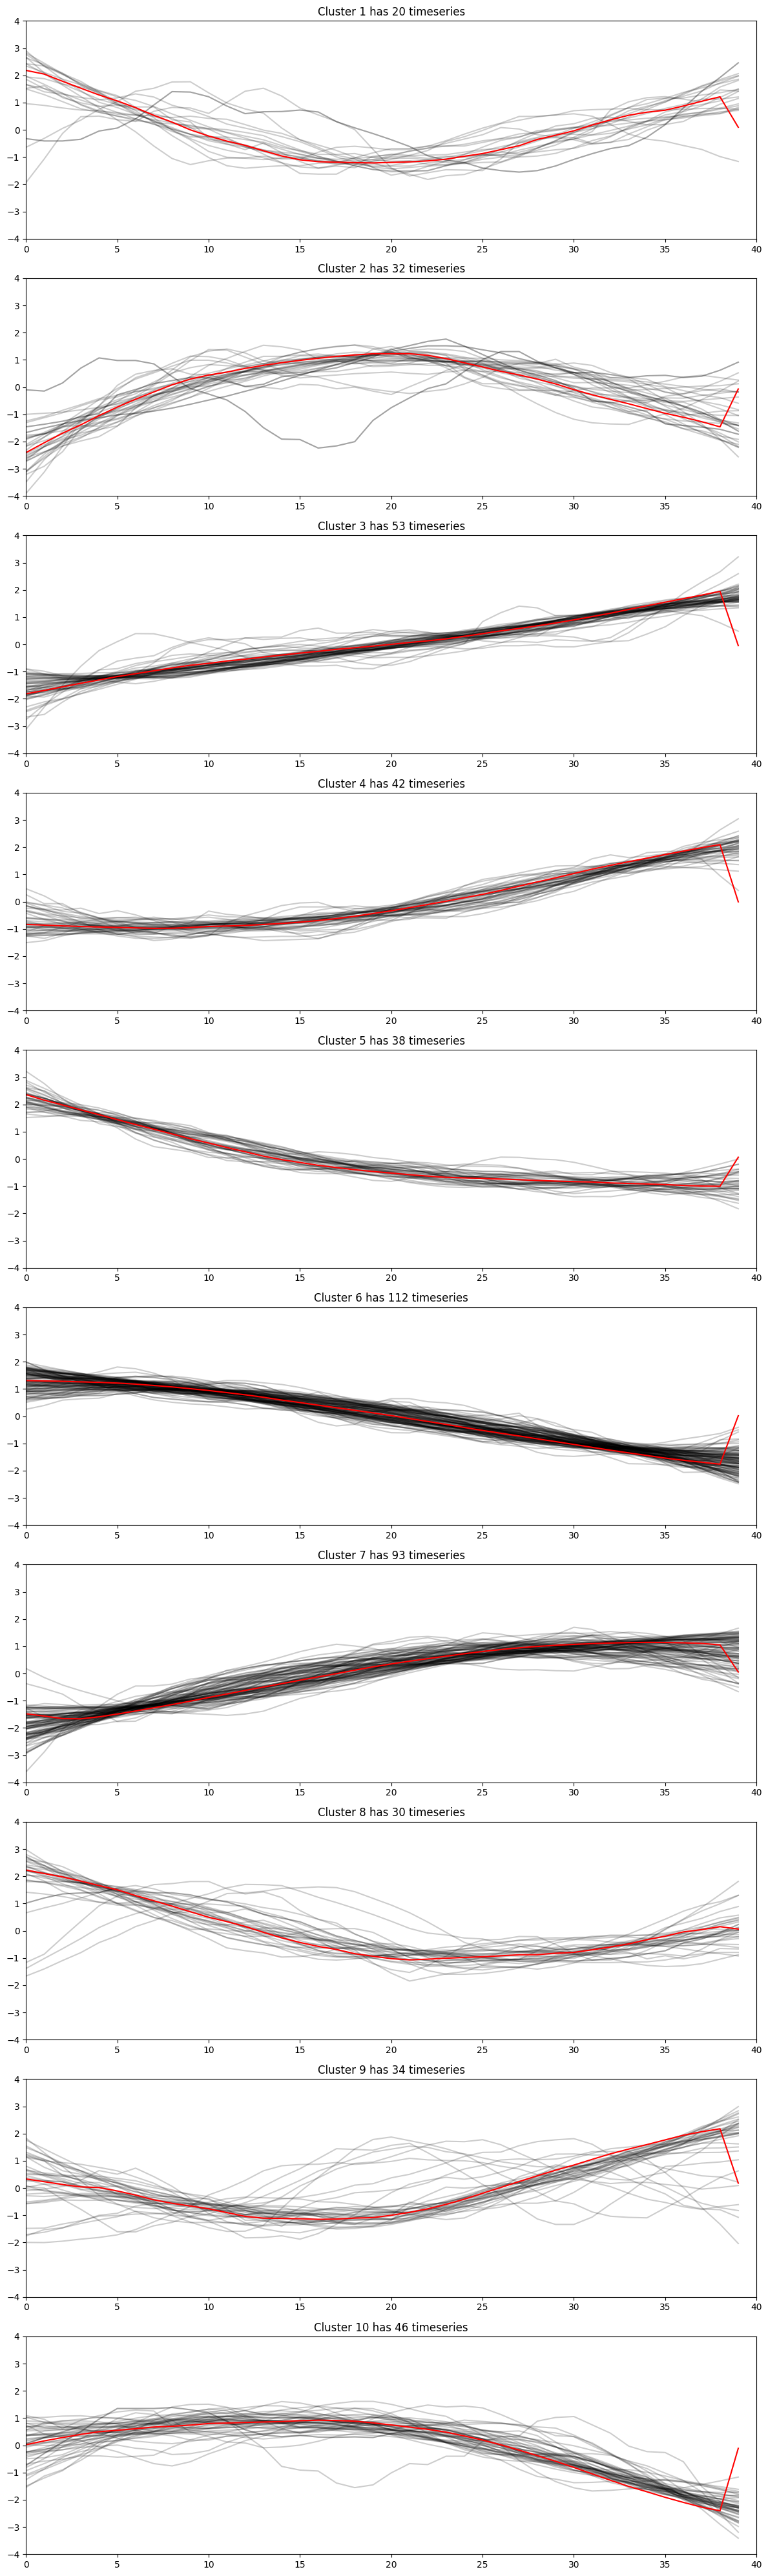

In [88]:
cluster_visuliation(mod, df_n, y_pred, 10)

100%|██████████| 5/5 [15:34<00:00, 186.88s/it]


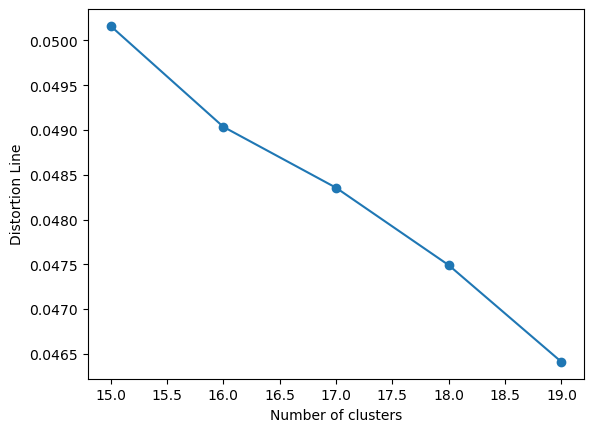

In [45]:
cl_num(df_n)